In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
import os
import shutil
import glob
import numpy as np
import pandas as pd
import cv2
import torch
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
ZIP_FILENAME = 'lgg-mri-segmentation.zip'
DRIVE_PATH = f'/content/drive/MyDrive/Colab Notebooks/Image segmentation of glioma/{ZIP_FILENAME}'
LOCAL_ZIP = f'/content/{ZIP_FILENAME}'
EXTRACT_DIR = '/content/dataset_unzipped'

if not os.path.exists(DRIVE_PATH):
    raise FileNotFoundError(f"Could not find '{ZIP_FILENAME}' in MyDrive. Please check the name.")

if not os.path.exists(LOCAL_ZIP):
    print(f"Copying {ZIP_FILENAME} to local runtime...")
    shutil.copy(DRIVE_PATH, LOCAL_ZIP)

if not os.path.exists(EXTRACT_DIR):
    print("Unzipping data...")
    os.makedirs(EXTRACT_DIR, exist_ok=True)
    os.system(f"unzip -q {LOCAL_ZIP} -d {EXTRACT_DIR}")
    print("Data ready!")
else:
    print("Data already unzipped.")

Copying lgg-mri-segmentation.zip to local runtime...
Unzipping data...
Data ready!


In [ ]:
def create_df(root_path):
    mask_files = glob.glob(os.path.join(root_path, '**/*_mask.tif'), recursive=True)
    data = []
    for mask_path in mask_files:
        img_path = mask_path.replace('_mask.tif', '.tif')
        if os.path.exists(img_path):
            data.append({"image": img_path, "mask": mask_path})
    return pd.DataFrame(data)

df = create_df(EXTRACT_DIR)
if len(df) == 0:
    raise ValueError("No images found! The zip file might be empty or have a different structure.")
print(f"Found {len(df)} images in the dataset.")
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

Found 3929 images in the dataset.


In [ ]:
CONFIG = {
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "EPOCHS": 15,
    "BATCH_SIZE": 32,
    "LEARNING_RATE": 0.0001,
    "IMAGE_SIZE": 256,
    "SAVE_PATH": "/content/drive/MyDrive/Colab Notebooks/Image segmentation of glioma/unet_mri_model.pth" # Save to Drive
}
print(f"Training on: {CONFIG['DEVICE']}")

Training on: cuda


In [ ]:
class MRI_Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Read Image
        image = cv2.imread(row['image'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read Mask
        mask = cv2.imread(row['mask'], cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1) / 255.0

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.float()

train_transforms = A.Compose([
    A.Resize(CONFIG['IMAGE_SIZE'], CONFIG['IMAGE_SIZE']),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.Normalize(),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(CONFIG['IMAGE_SIZE'], CONFIG['IMAGE_SIZE']),
    A.Normalize(),
    ToTensorV2()
])

# DataLoaders
train_loader = DataLoader(MRI_Dataset(train_df, transform=train_transforms), batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=2, pin_memory=True)

val_loader = DataLoader(MRI_Dataset(val_df, transform=val_transforms), batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
model = smp.Unet(encoder_name="resnet34",encoder_weights="imagenet",in_channels=3,classes=1,activation=None).to(CONFIG['DEVICE'])
loss_fn = smp.losses.DiceLoss(mode='binary', from_logits=True)
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['LEARNING_RATE'])
scaler = torch.amp.GradScaler('cuda')

In [ ]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0

    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            logits = model(images)
            loss = loss_fn(logits, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
    return running_loss / len(loader)

In [ ]:
def validate(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            logits = model(images)
            loss = loss_fn(logits, masks)
            running_loss += loss.item()
    return running_loss / len(loader)

In [ ]:
print("\n--- Step 3: Starting Training ---")
best_loss = float('inf')
for epoch in range(CONFIG['EPOCHS']):
    t_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, CONFIG['DEVICE'])
    v_loss = validate(model, val_loader, loss_fn, CONFIG['DEVICE'])

    print(f"Epoch {epoch+1}/{CONFIG['EPOCHS']} | Train Loss: {t_loss:.4f} | Val Loss: {v_loss:.4f}")

    # Save best model to Drive
    if v_loss < best_loss:
        best_loss = v_loss
        torch.save(model.state_dict(), CONFIG['SAVE_PATH'])
        print(f"Model saved to: {CONFIG['SAVE_PATH']}")

print("\nTraining Complete. Check your Google Drive for the model file.")


--- Step 3: Starting Training ---
Epoch 1/15 | Train Loss: 0.9526 | Val Loss: 0.9439
Model saved to: /content/drive/MyDrive/Colab Notebooks/Image segmentation of glioma/unet_mri_model.pth
Epoch 2/15 | Train Loss: 0.9111 | Val Loss: 0.8973
Model saved to: /content/drive/MyDrive/Colab Notebooks/Image segmentation of glioma/unet_mri_model.pth
Epoch 3/15 | Train Loss: 0.8213 | Val Loss: 0.7866
Model saved to: /content/drive/MyDrive/Colab Notebooks/Image segmentation of glioma/unet_mri_model.pth
Epoch 4/15 | Train Loss: 0.6624 | Val Loss: 0.5791
Model saved to: /content/drive/MyDrive/Colab Notebooks/Image segmentation of glioma/unet_mri_model.pth
Epoch 5/15 | Train Loss: 0.4266 | Val Loss: 0.3730
Model saved to: /content/drive/MyDrive/Colab Notebooks/Image segmentation of glioma/unet_mri_model.pth
Epoch 6/15 | Train Loss: 0.2682 | Val Loss: 0.2526
Model saved to: /content/drive/MyDrive/Colab Notebooks/Image segmentation of glioma/unet_mri_model.pth
Epoch 7/15 | Train Loss: 0.1955 | Val Los

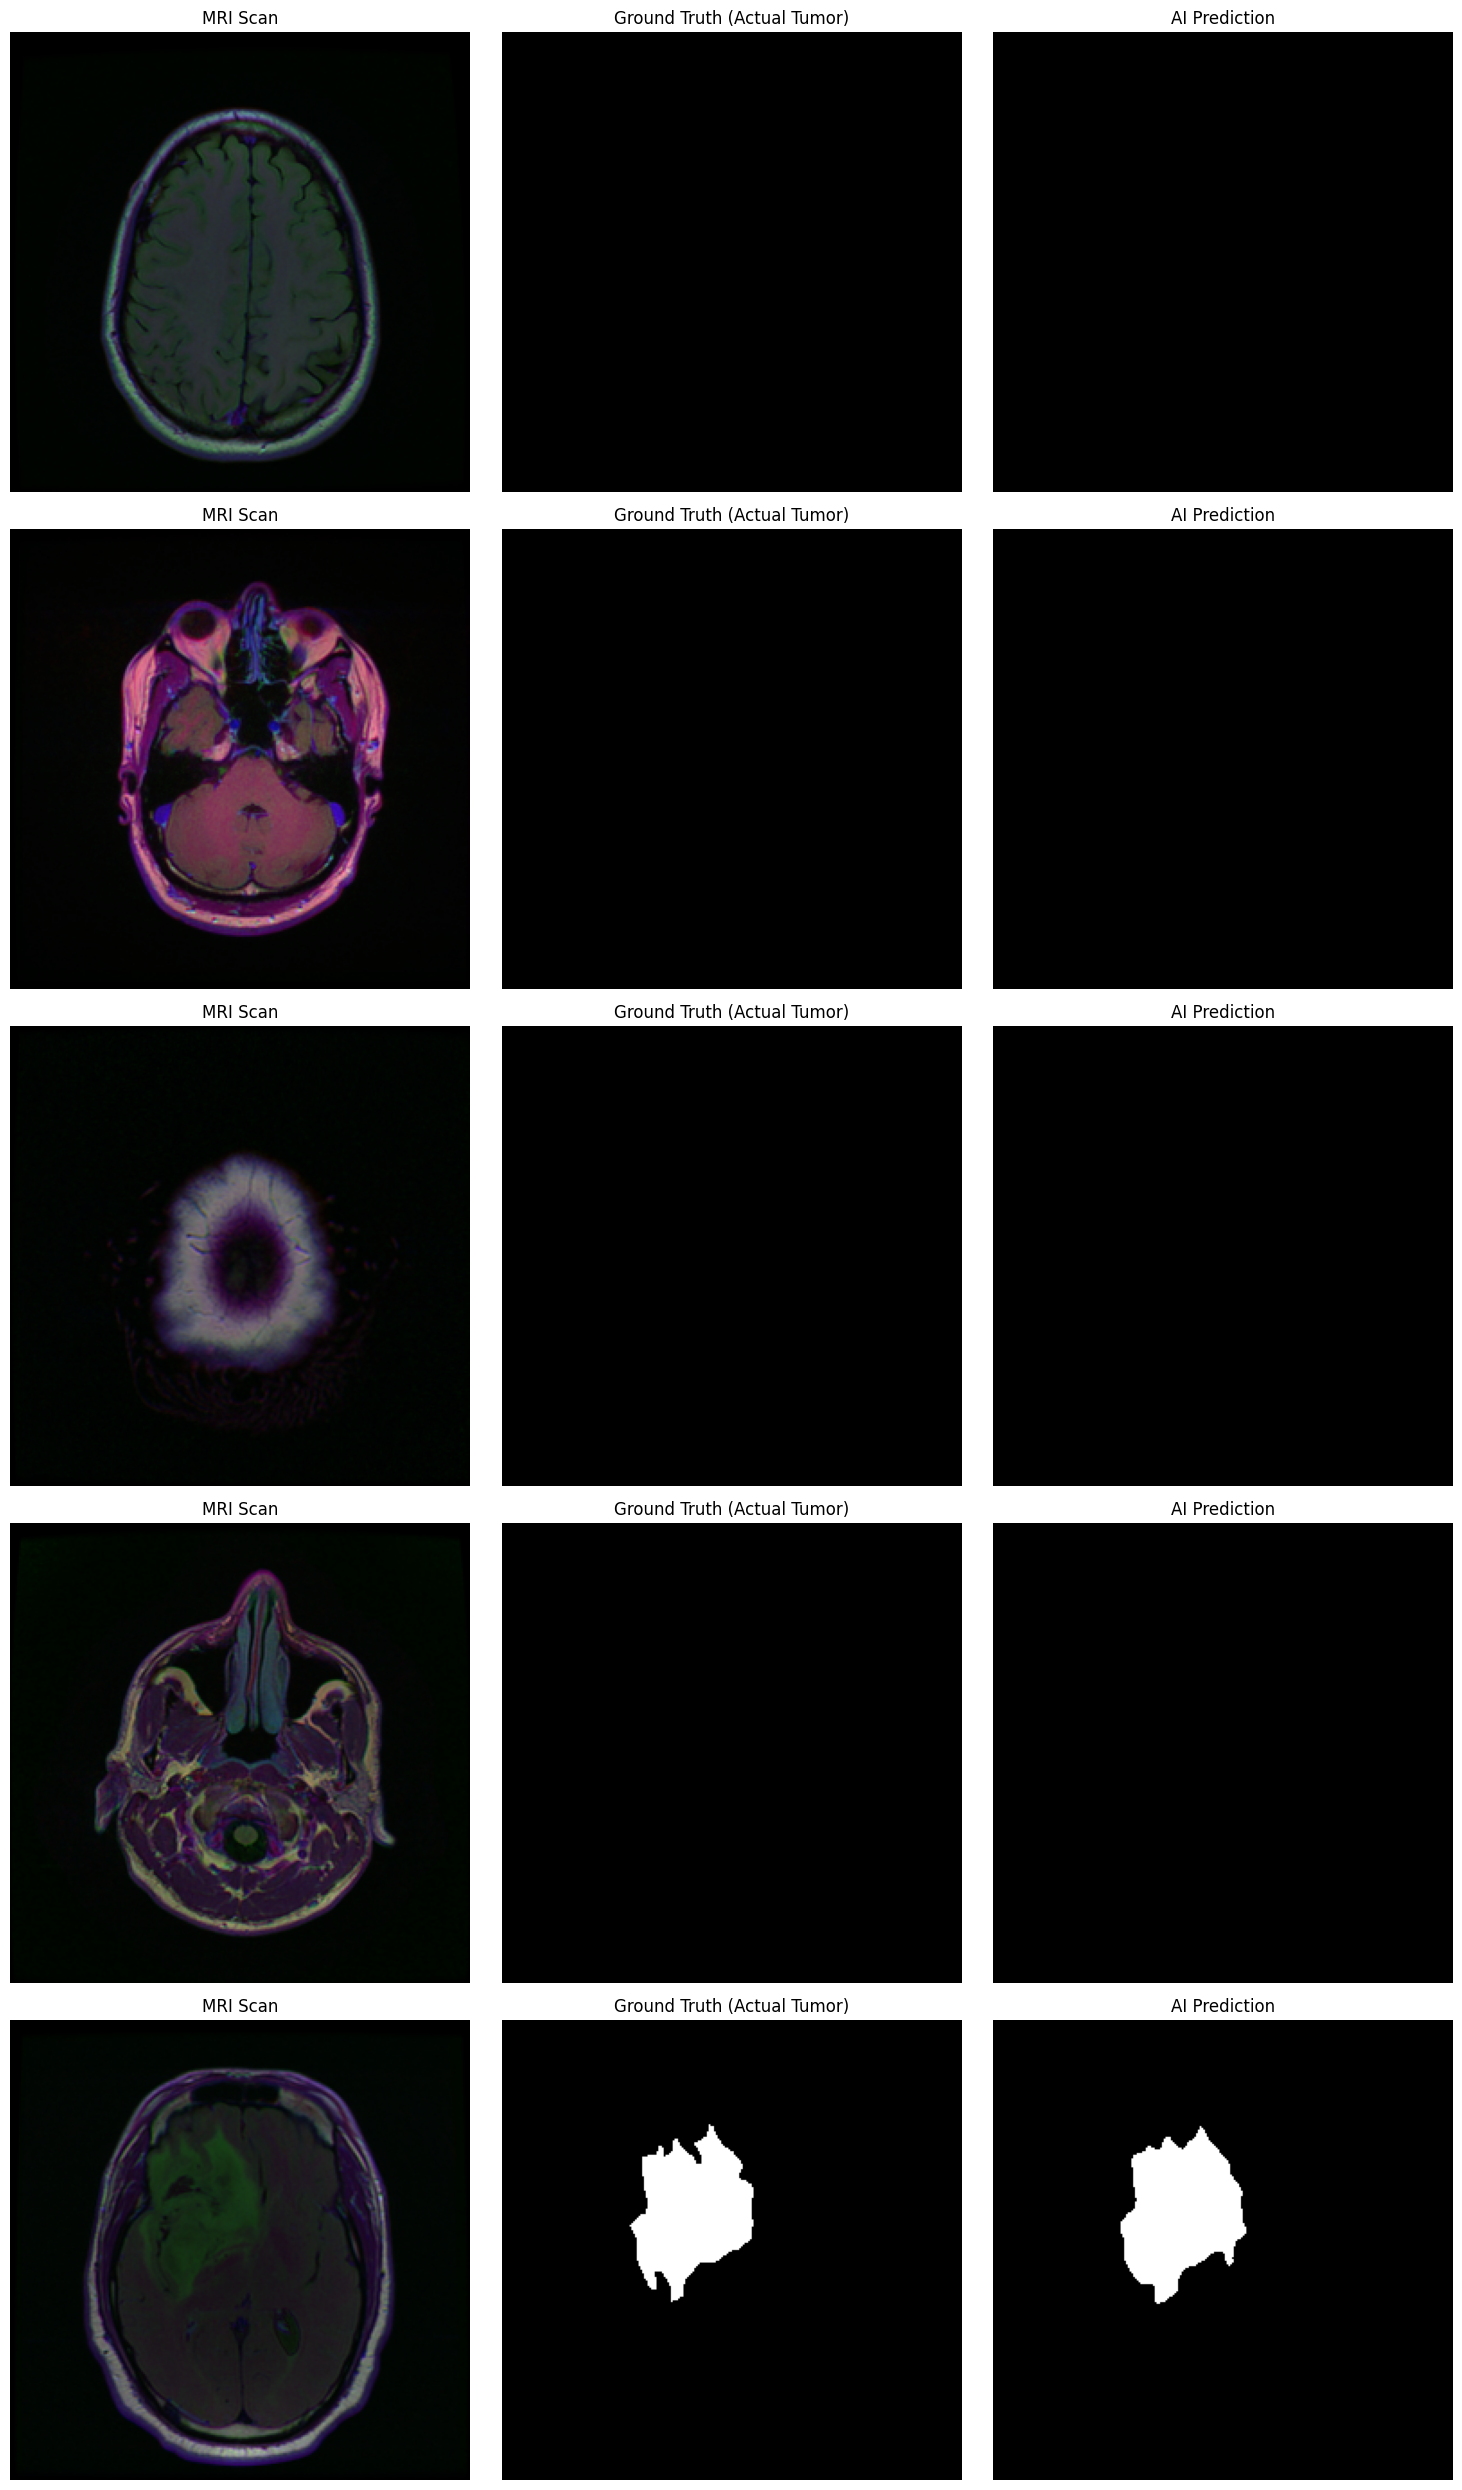

In [ ]:
import matplotlib.pyplot as plt

model.load_state_dict(torch.load(CONFIG['SAVE_PATH']))
model.eval()

images, masks = next(iter(val_loader))
images = images.to(CONFIG['DEVICE'])

with torch.no_grad():
    logits = model(images)
    pr_masks = torch.sigmoid(logits)
    pr_masks = (pr_masks > 0.5).float()

def show_results(images, true_masks, pred_masks, num_samples=5):
    images = images.cpu().numpy()
    true_masks = true_masks.cpu().numpy()
    pred_masks = pred_masks.cpu().numpy()

    fig, ax = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for i in range(num_samples):
        img = np.transpose(images[i], (1, 2, 0))

        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        ax[i, 0].imshow(img)
        ax[i, 0].set_title("MRI Scan")
        ax[i, 0].axis("off")

        ax[i, 1].imshow(true_masks[i].squeeze(), cmap="gray")
        ax[i, 1].set_title("Ground Truth (Actual Tumor)")
        ax[i, 1].axis("off")

        ax[i, 2].imshow(pred_masks[i].squeeze(), cmap="gray")
        ax[i, 2].set_title("AI Prediction")
        ax[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

show_results(images, masks, pr_masks, num_samples=5)